In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fareselmenshawii/face-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.43G/4.43G [07:02<00:00, 11.3MB/s]

Extracting files...


Path to dataset files: /Users/ihorkostiuk/.cache/kagglehub/datasets/fareselmenshawii/face-detection-dataset/versions/3


In [27]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Literal
from tqdm import tqdm
import numpy as np

images_folder = Path("/Users/ihorkostiuk/.cache/kagglehub/datasets/fareselmenshawii/face-detection-dataset/versions/3/images/train/")
annotations_folder = Path("/Users/ihorkostiuk/.cache/kagglehub/datasets/fareselmenshawii/face-detection-dataset/versions/3/labels/train/")


def read_annotation(annotation: Path) -> list[tuple[float, float, float, float]]:
    
    result = []
    
    for line in annotation.read_text().splitlines():
        
        line = line.strip()
        
        result.append(
            [float(value) for value in line.split(" ")][1:]
        )

    return result


def dataset_analysis(
    images_root: Path, 
    annotations_root: Path, 
    subset: Literal["train", "val"]
) -> tuple[int, int]:
    
    images_folder = images_root / subset
    annotations_folder = annotations_root / subset
    
    images = list(images_folder.glob("*.*"))
    n_labels = 0
    
    for image in tqdm(images, total=len(images)):
        
        annotation_path = annotations_folder / f"{image.stem}.txt"
        
        n_labels += len(read_annotation(annotation_path))
    
    print(f"Number of images in the {subset} subset is: {len(images)}")
    print(f"Number of annotations in the {subset} subset is: {n_labels}")
    
    return len(images), n_labels


def analyse_images_ratios(
    labels_root: Path,
    subset: Literal["train", "val"]
) -> tuple[cv2.Mat, cv2.Mat]:
    """
    Returns
    -------
    tuple[cv2.Mat, cv2.Mat]
        - Image with possible locations
        - Image with possible ratios
    """
    annotations_folder = labels_root / subset
    
    locations_image = np.full((1000, 1000, 3), fill_value=255, dtype=np.uint8)
    ratios_image = np.full((1000, 1000, 3), fill_value=255, dtype=np.uint8)
    
    for annotation_path in annotations_folder.glob("*.txt"):
        
        for center_x_norm, center_y_norm, width_norm, height_norm in read_annotation(annotation_path):

            width = int(width_norm * 1000)
            height = int(height_norm * 1000)
            
            xmin = int(center_x_norm * 1000 - width / 2)
            ymin = int(center_y_norm * 1000 - height / 2)
            xmax = xmin + width
            ymax = ymin + height
            
            locations_image = cv2.rectangle(
                locations_image,
                (xmin, ymin),
                (xmax, ymax),
                [0, 255, 0],
                2
            )
            
            ratios_image = cv2.rectangle(
                ratios_image,
                (500 - width // 2, 500 - height // 2),
                (500 + width // 2, 500 + height // 2),
                [0, 255, 0],
                2
            )
        
    return locations_image, ratios_image


def draw_example(index: int) -> None:
    
    image_path = list(images_folder.glob("*.*"))[index]
    annotation_path = annotations_folder / f"{image_path.stem}.txt"
    
    image = cv2.imread(image_path)
    annotations = read_annotation(annotation_path)
    
    image_height, image_width = image.shape[:2]
    
    for center_x_norm, center_y_norm, width_norm, height_norm in annotations:
        
        width = int(width_norm * image_width)
        height = int(height_norm * image_height)
        
        xmin = int(center_x_norm * image_width - width / 2)
        ymin = int(center_y_norm * image_height - height / 2)
        xmax = xmin + width
        ymax = ymin + height
        
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), [0, 255, 0], 3)
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    plt.imshow(image)

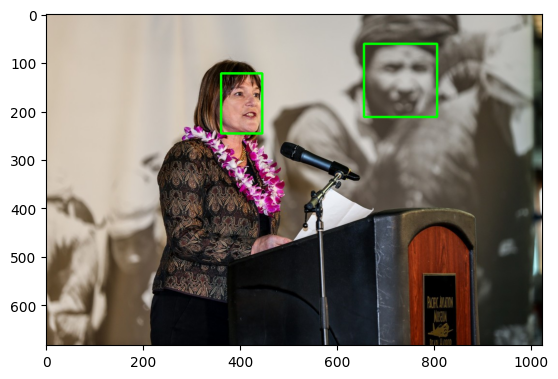

In [17]:
draw_example(1)

In [18]:
images_root = Path("/Users/ihorkostiuk/.cache/kagglehub/datasets/fareselmenshawii/face-detection-dataset/versions/3/images/")
annotations_root = Path("/Users/ihorkostiuk/.cache/kagglehub/datasets/fareselmenshawii/face-detection-dataset/versions/3/labels/")

n_train_images, n_train_labels = dataset_analysis(
    images_root=images_root,
    annotations_root=annotations_root,
    subset="train"
)

n_val_images, n_val_labels = dataset_analysis(
    images_root=images_root,
    annotations_root=annotations_root,
    subset="val"
)

100%|██████████| 13386/13386 [00:00<00:00, 37939.80it/s]


Number of images in the train subset is: 13386
Number of annotations in the train subset is: 41547


100%|██████████| 3347/3347 [00:00<00:00, 37251.79it/s]

Number of images in the val subset is: 3347
Number of annotations in the val subset is: 10299


Text(0, 0.5, 'Number of images')

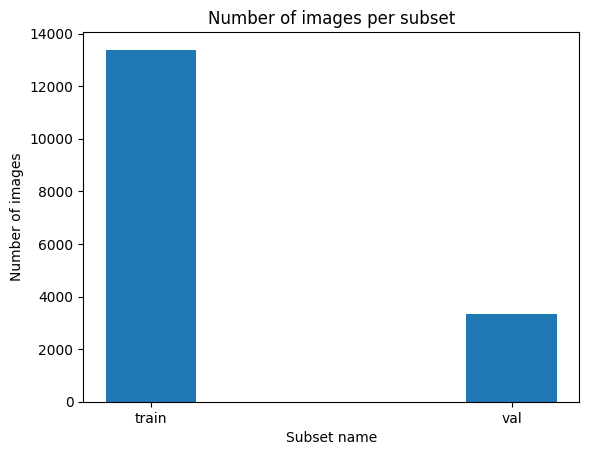

In [22]:
locations = [0, 1]
width = 0.25


ax = plt.subplot()

ax.bar(
    locations,
    [n_train_images, n_val_images],
    width
)

ax.set_xticks(
    locations,
    labels=["train", "val"]
)

ax.set_title(
    "Number of images per subset"
)

ax.set_xlabel("Subset name")

ax.set_ylabel("Number of images")

Text(0, 0.5, 'Number of labels')

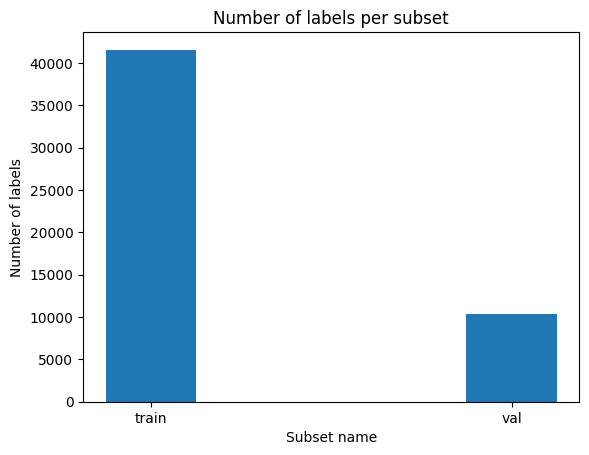

In [23]:
locations = [0, 1]
width = 0.25


ax = plt.subplot()

ax.bar(
    locations,
    [n_train_labels, n_val_labels],
    width
)

ax.set_xticks(
    locations,
    labels=["train", "val"]
)

ax.set_title(
    "Number of labels per subset"
)

ax.set_xlabel("Subset name")

ax.set_ylabel("Number of labels")

Text(0.5, 1.0, 'Ratios of the bounding boxes.')

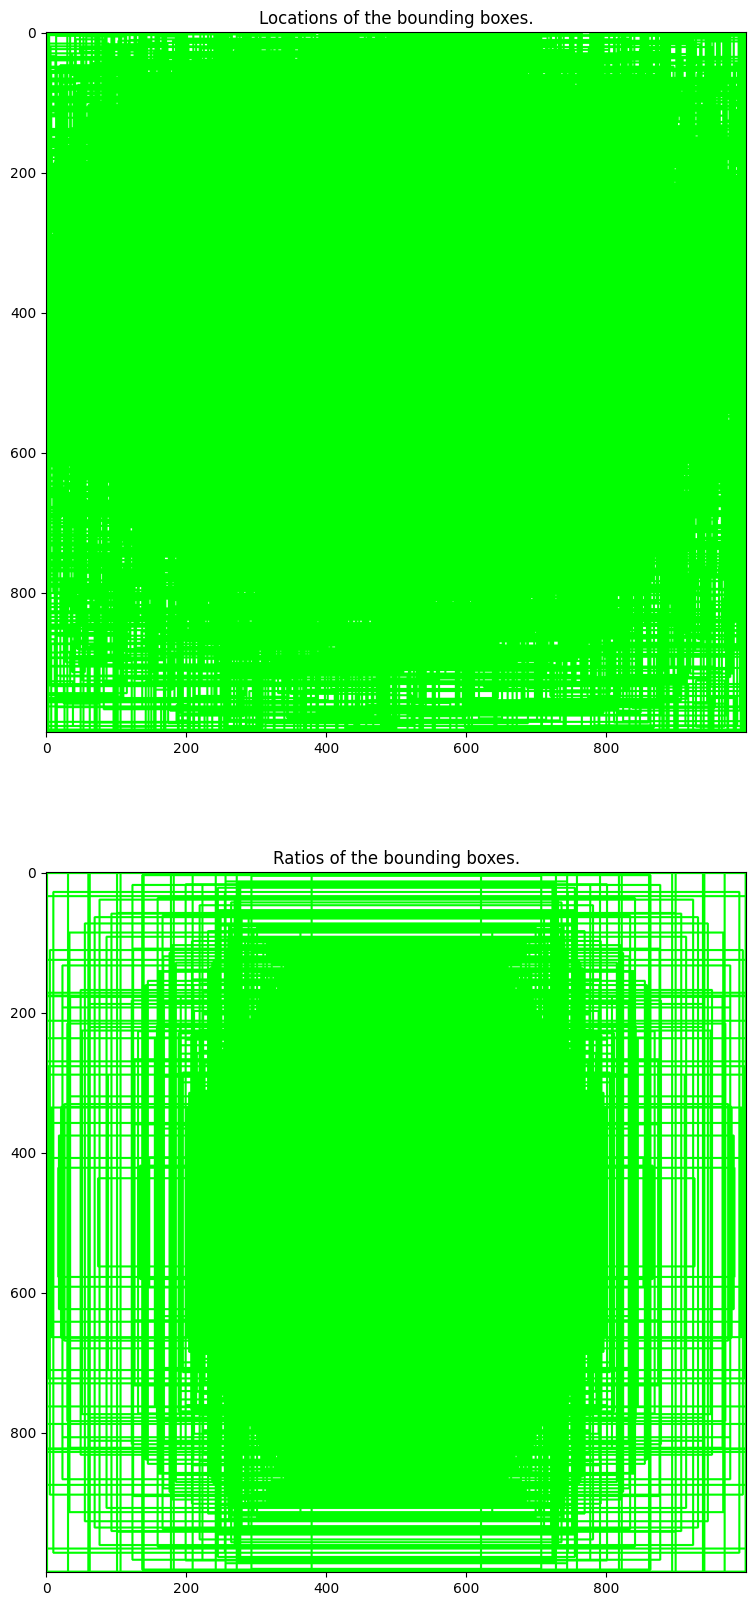

In [32]:
locations_image, ratios_image = analyse_images_ratios(
    labels_root=annotations_root,
    subset="val"
)

fig, axes = plt.subplots(nrows=2, ncols=1)

fig.set_size_inches(20, 20)

axes[0].imshow(locations_image)
axes[0].set_title("Locations of the bounding boxes.")

axes[1].imshow(ratios_image)
axes[1].set_title("Ratios of the bounding boxes.")